In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt


In [2]:
#Load plasmid data
plasmid_dict = isoio.load('../data/prepared_data/apa_plasmid_data_v2/apa_plasmid_data_v2')
plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
#Load plasmid test set predictions

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

test_pred_dict = isoio.load('predictions/apa_plasmid_data/' + model_name + '_test_predictions')
test_pred_df = test_pred_dict['plasmid_df']
test_cuts_pred = test_pred_dict['cut_prob']


In [4]:
#Join dataframe with prediction table and calculate true cut probabilities

plasmid_df['row_index'] = np.arange(len(plasmid_df), dtype=np.int)
test_pred_df['row_index'] = np.arange(len(test_pred_df), dtype=np.int)

test_df = plasmid_df.join(test_pred_df.set_index('seq'), on='seq', how='inner', lsuffix='_true', rsuffix='_pred')

test_cuts_true = plasmid_cuts[np.ravel(test_df['row_index_true']), :]
cut_true = np.concatenate([np.array(test_cuts_true[:, 180: 180 + 205].todense()), np.array(test_cuts_true[:, -1].todense()).reshape(-1, 1)], axis=-1)
count_true = np.sum(cut_true, axis=-1)
cut_true = cut_true / np.sum(cut_true, axis=-1).reshape(-1, 1)

cut_pred = np.array(test_cuts_pred[np.ravel(test_df['row_index_pred']), :].todense())

#Calculate isoform proportions and log odds values

iso_true = np.sum(cut_true[:, 80: 80 + 30], axis=-1)
iso_pred = np.ravel(test_df['iso_pred'])
iso_pred_from_cuts = np.sum(cut_pred[:, 80: 80 + 30], axis=-1)

lib = np.array(test_df['library'].values, dtype=np.object)
lib_index = np.array(test_df['library_index'].values, dtype=np.int)


In [5]:

def plot_isoform_logodds_scatter(iso_true, iso_pred, count_true, lib_index, included_libs, min_count=1., vmin=-6., vmax=6., model_name=None, x_label='Predicted Isoform Log Odds', y_label='Observed Isoform Log Odds') :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    #Filter nan-logits
    keep_index = (keep_index & (count_true >= min_count)) & ((iso_true > 1e-7) & (iso_true < 1. - 1e-7))
    iso_true = iso_true[keep_index]
    iso_pred = iso_pred[keep_index]
    lib_index = lib_index[keep_index]

    logodds_true = np.log(iso_true / (1. - iso_true))
    logodds_pred = np.log(iso_pred / (1. - iso_pred))
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(logodds_pred, logodds_true)
    spearman_r_val, _ = spearmanr(logodds_pred, logodds_true)
    
    #Compute mean correlations across libraries
    r_vals = []
    spearman_r_vals = []
    for i, li in enumerate(included_libs) :
        
        iso_true_lib = iso_true[lib_index == li]
        iso_pred_lib = iso_pred[lib_index == li]
        
        iso_true_lib = np.log(iso_true_lib / (1. - iso_true_lib))
        iso_pred_lib = np.log(iso_pred_lib / (1. - iso_pred_lib))

        r_val_lib, _ = pearsonr(iso_pred_lib, iso_true_lib)
        spearman_r_val_lib, _ = spearmanr(iso_pred_lib, iso_true_lib)
        
        r_vals.append(r_val_lib)
        spearman_r_vals.append(spearman_r_val_lib)

    print('Isoform Log Odds Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true.shape[0]))
    print('Isoform Log Odds Test Set Spearman r = ' + str(round(spearman_r_val, 2)) + ', n = ' + str(iso_true.shape[0]))

    print('Mean R^2 = ' + str(round(np.mean(r_vals)**2, 2)) + ', n = ' + str(iso_true.shape[0]))
    print('Mean Spearman r = ' + str(round(np.mean(spearman_r_vals), 2)) + ', n = ' + str(iso_true.shape[0]))
    
    f = plt.figure(figsize=(5, 5))

    plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.05, color='black')
    
    plt.plot([vmin, vmax], [vmin, vmax], alpha=0.5, color='darkblue', linewidth=3)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    if model_name is not None :
        plt.savefig(model_name + "_isoform_scatter_test.png", transparent=True, dpi=300)
        plt.savefig(model_name + "_isoform_scatter_test.eps")
    
    plt.show()
    plt.close()


Evaluate test set of all random libraries
Isoform Log Odds Test Set R^2 = 0.89, n = 77423
Isoform Log Odds Test Set Spearman r = 0.94, n = 77423
Mean R^2 = 0.71, n = 77423
Mean Spearman r = 0.83, n = 77423


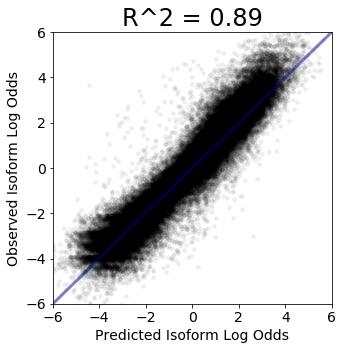

Evaluate test set of Alien1
Isoform Log Odds Test Set R^2 = 0.88, n = 7755
Isoform Log Odds Test Set Spearman r = 0.93, n = 7755
Mean R^2 = 0.88, n = 7755
Mean Spearman r = 0.93, n = 7755


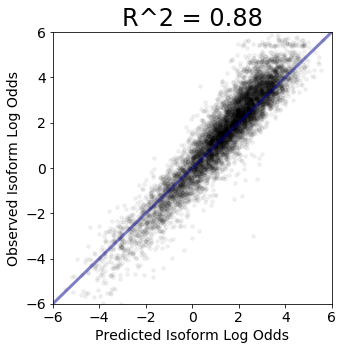

In [6]:
#Evaluate test set isoform prediction performance over all random libraries

print("Evaluate test set of all random libraries")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34]

plot_isoform_logodds_scatter(iso_true, iso_pred, count_true, lib_index, included_libs, min_count=1., vmin=-6., vmax=6., model_name=model_name)

print("Evaluate test set of Alien1")

included_libs = [22]

plot_isoform_logodds_scatter(iso_true, iso_pred, count_true, lib_index, included_libs, min_count=1., vmin=-6., vmax=6., model_name=model_name + "_alien_1")


Evaluate test set of all random libraries
Isoform Log Odds Test Set R^2 = 0.9, n = 60198
Isoform Log Odds Test Set Spearman r = 0.95, n = 60198
Mean R^2 = 0.76, n = 60198
Mean Spearman r = 0.86, n = 60198


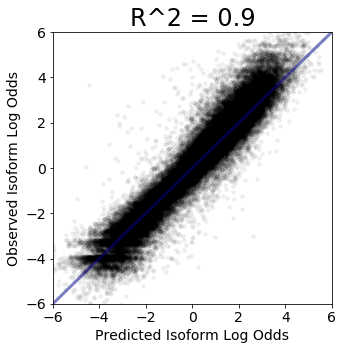

Evaluate test set of Alien1
Isoform Log Odds Test Set R^2 = 0.88, n = 7755
Isoform Log Odds Test Set Spearman r = 0.93, n = 7755
Mean R^2 = 0.88, n = 7755
Mean Spearman r = 0.93, n = 7755


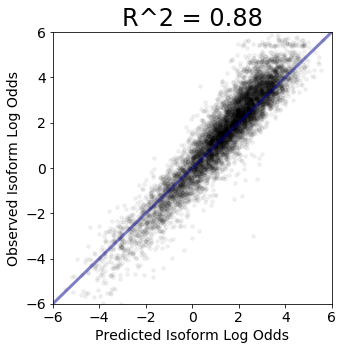

In [13]:
#Evaluate test set isoform prediction performance over all random libraries

print("Evaluate test set of all random libraries")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34]

plot_isoform_logodds_scatter(iso_true, iso_pred, count_true, lib_index, included_libs, min_count=50., vmin=-6., vmax=6., model_name=model_name + "_high_count")

print("Evaluate test set of Alien1")

included_libs = [22]

plot_isoform_logodds_scatter(iso_true, iso_pred, count_true, lib_index, included_libs, min_count=50., vmin=-6., vmax=6., model_name=model_name + "_high_count" + "_alien_1")


In [11]:
def plot_cut_position_scatters(cut_true, cut_pred, lib_index, included_libs, model_name=None, vmin=-6., vmax=6.) :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    cut_start = 77
    cut_end = 127
    
    #Filter nan-logits
    keep_index = keep_index & (np.sum(cut_true[:, cut_start:cut_end], axis=-1) > 0.5)
    cut_true = cut_true[keep_index, :]
    cut_pred = cut_pred[keep_index, :]
    lib_index = lib_index[keep_index]
    
    cut_true = cut_true[:, cut_start:cut_end] / np.sum(cut_true[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    cut_pred = cut_pred[:, cut_start:cut_end] / np.sum(cut_pred[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    
    mean_cut_true = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_true, axis=-1)
    mean_cut_pred = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_pred, axis=-1)
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(mean_cut_pred, mean_cut_true)
    spearman_r_val, _ = spearmanr(mean_cut_pred, mean_cut_true)

    print('Mean Cut Position Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(cut_true.shape[0]))
    print('Mean Cut Position Test Set Spearman r = ' + str(round(spearman_r_val, 2)) + ', n = ' + str(cut_true.shape[0]))
    
    f, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].scatter(mean_cut_pred, mean_cut_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')

    plt.sca(ax[0])
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("True Mean Cut Position", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    sort_index = np.argsort(mean_cut_true)
    mean_cut_true = mean_cut_true[sort_index]
    mean_cut_pred = mean_cut_pred[sort_index]

    ax[1].scatter(mean_cut_pred, np.arange(mean_cut_true.shape[0]), s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')
    ax[1].plot(mean_cut_true, np.arange(mean_cut_true.shape[0]), color='darkred', linewidth=3, linestyle='--')
    
    plt.sca(ax[1])
    
    plt.xlim(vmin, vmax)
    
    plt.xticks(fontsize=14)
    plt.yticks([], fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("Sequences", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    plt.tight_layout()
    
    if model_name is not None :
        plt.savefig(model_name + "_cut_scatter_test.png", transparent=True, dpi=300)
        plt.savefig(model_name + "_cut_scatter_test.eps")
    
    plt.show()
    plt.close()



Evaluate test set cut site prediction on Alien1 library
Mean Cut Position Test Set R^2 = 0.89, n = 6203
Mean Cut Position Test Set Spearman r = 0.93, n = 6203


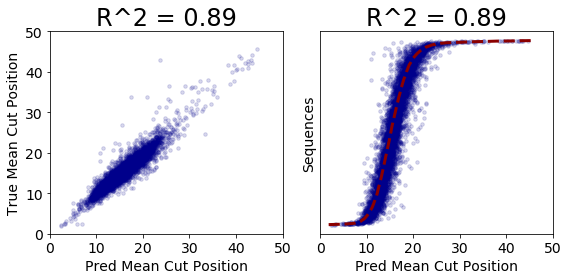

In [12]:
#Evaluate predicted vs. observed mean cut position on test sets

print("Evaluate test set cut site prediction on Alien1 library")

plot_cut_position_scatters(cut_true, cut_pred, lib_index, [22], model_name=model_name, vmin=0., vmax=50)
